# Hybrid Univariate #3

We are training a seperate model for each timestep in the lookahead window; univaraite input and output
We are feeding the output of the previous model to each succesive model

Fixed an error in the code with Hybrid Univariate #2, metrics and training loss behaving as expected

## Load functions and data

In [32]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras import callbacks
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

import datetime 
from datetime import timedelta
from datetime import datetime

In [2]:
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_start_ix = end_ix + n_step_lookahead -1
        out_end_ix = end_ix + n_steps_out + n_step_lookahead -1
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[out_start_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [3]:
#To demonstrate above function
sequence = range(0,13)
n_steps_in = 1
n_steps_in = 5
n_steps_out =1
step_interval =1
n_step_lookahead=5
split_sequence(sequence, n_steps_in, n_steps_out, step_interval, n_step_lookahead)

(array([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]]),
 array([[ 9],
        [10],
        [11],
        [12]]))

In [4]:
percentile_data = pd.read_csv (r'C:\Users/conal/Desktop/MCM/Practicum - Copy/data/block gas price percentile data.csv', header=0)
percentile_data['datetime'] = pd.to_datetime(percentile_data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')

percentile_data = percentile_data.sort_values(by='datetime',ascending=False)
percentile_data = percentile_data.set_index('datetime')
percentile_data = percentile_data.resample('5T').mean()
percentile_data = percentile_data/1000000000

In [5]:
usage_data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\ETH,gas,usage merged 11-26 to 05-26.csv', header=0)
usage_data['datetime'] = pd.to_datetime(usage_data['datetime'], format = '%Y-%m-%d %H:%M:%S')
usage_data = usage_data.set_index('datetime')

usage_data = usage_data.squeeze()
usage_data = usage_data.astype('float')
usage_data = usage_data.resample('5T').mean()

In [6]:
usage_data2 = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum - Copy\data\Contract counts 2021-11-26 to 2022-05-26.csv', header=0, index_col=0)
usage_data2['datetime'] = pd.to_datetime(usage_data2['block_timestamp'], format = '%Y-%m-%d %H:%M:%S') 
usage_data2 = usage_data2.set_index('datetime')
usage_data2 = usage_data2.drop(['block_timestamp'], axis=1)
usage_data2 = usage_data2.squeeze()
usage_data2 = usage_data2.astype('float')
usage_data2 = usage_data2.resample('5T').sum()

In [7]:
data = usage_data.merge(percentile_data, left_index=True, right_index=True)
data = data.merge(usage_data2, left_index=True, right_index=True)

Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [8]:
def generate_training_val_examples_univariate_output(data):
 
    #Filter inputs, standardize
    data =data[inputs]
    scaler = StandardScaler()
    data[inputs] = scaler.fit_transform(data[inputs])
    

    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    
    y_train, y_val = np.split(y, [int(0.7 * len(X))])

    
    #Reshape to 3D for LSTM, filter output to only the first input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))[:,:,:1]
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))[:,:,:1]

    
    return X_train, y_train, X_val, y_val, scaler


In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


In [10]:
def descale_y_retrun_metrics(yhat, y_val2):
    #reverts standard scaling, returns dictionary of metrics for each output, for all lookaheads
    dict_indexes=[]
    dict_dfs=[]
    for j in range(0, n_steps_out):
        RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
        for i in range(0, len(inputs)):  
            pred_descaled= (scaler.inverse_transform(yhat[:,j:j+1,:].reshape(yhat.shape[0], yhat.shape[2])))[:, i:i+1]
            groud_truth_descaled= ((scaler.inverse_transform(y_val2[:,j:j+1,:].reshape(y_val2.shape[0], y_val2.shape[2]))))[:, i:i+1]
            RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
            MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
            MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
            MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
            R2 = r2_score(groud_truth_descaled, pred_descaled)
            RMSE_list.append(RMSE)
            MAE_list.append(MAE)
            MAPE_list.append(MAPE)
            R2_list.append(R2)
            MSE_list.append(MSE)
        metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=inputs)
        dict_dfs.append(metrics_df)
        dict_indexes.append('Lookahead' +str(j))
    metrics_dict = dict(zip(dict_indexes, dict_dfs))
    return metrics_dict

In [11]:
def descale_y_retrun_metrics_univariate_y(yhat, y_val2):
    #reverts standard scaling, returns dictionary of metrics for single output, for all lookaheads
    dict_indexes=[]
    dict_dfs=[]
    RMSE_list, MAE_list, MAPE_list, R2_list, MSE_list = [],[],[],[],[]
    for j in range(0, n_steps_out):
        pred_descaled= scaler.inverse_transform(yhat)
        groud_truth_descaled= scaler.inverse_transform(y_val2[:,0,])
        RMSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)
        MSE = mean_squared_error(groud_truth_descaled, pred_descaled, squared=True)
        MAE = mean_absolute_error(groud_truth_descaled, pred_descaled)
        MAPE = mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)
        R2 = r2_score(groud_truth_descaled, pred_descaled)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)
        MAPE_list.append(MAPE)
        R2_list.append(R2)
        MSE_list.append(MSE)
    metrics_df = pd.DataFrame({'RMSE':RMSE_list, 'MSE':MSE_list, 'MAE':MAE_list, 'MAPE':MAPE_list, 'R2':R2_list}, index=range(1, (n_steps_out+1)))

 
    return metrics_df

In [12]:
def LSTM_model():
    checkpoint_filepath='./Hybrid Univarite2/'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
    model = Sequential()
    model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    return model, model_checkpoint_callback, checkpoint_filepath

## Training loop

In [63]:
end_dates = ['2021-12-26 23:55:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00', '2022-04-26 23:55:00'  ]
Start_dates = ['2021-11-26 00:00:00', '2021-12-26 00:00:00', '2022-01-26 23:55:00', '2022-02-26 23:55:00', '2022-03-26 23:55:00']

#Create Training Examples for all lookaheads
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1

y_hat_list=[]
train_loss_list=[]
val_loss_list=[]
training_metrics_dicts=[]
valdiation_metrics_dicts=[]
for month in [0, 1, 2, 3, 4]:
    n_step_lookahead=1
    start_date=Start_dates[month]
    end_date=end_dates[month]
    X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)
    for i in range(1,11):
        n_step_lookahead = i
     


        model, model_checkpoint_callback, checkpoint_filepath = LSTM_model()
        train_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, verbose=1, callbacks=[model_checkpoint_callback])
        model.load_weights(checkpoint_filepath)
        model.save(('Hybrid Univarite3/month' +str(month)+'_'+ str(i) + '_step_lookahead_Hybrid'))

        yhat_train = model.predict(X_train, verbose=1)
        yhat_val = model.predict(X_val, verbose=1)
        y_hat_list.append(yhat_val)

        train_loss_list.append(train_history.history['loss'])
        val_loss_list.append(train_history.history['val_loss'])
        pd.DataFrame(train_loss_list).to_csv('Hybrid Univarite3/train_loss')
        pd.DataFrame(val_loss_list).to_csv('Hybrid Univarite3/val_loss')
        
        training_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_train, y_train))
        valdiation_metrics_dicts.append(descale_y_retrun_metrics_univariate_y(yhat_val, y_val))

    
        x_train_extended = []
        for j in range(0, len(X_train)):
            X_train_t = np.append(X_train[j], yhat_train[j])
            x_train_extended.append(X_train_t)

        x_val_extended = []
        for k in range(0, len(X_val)):
            X_val_t = np.append(X_val[k], yhat_val[k])
            x_val_extended.append(X_val_t)

        n_step_lookahead = i+1
        X_traindummy, y_train, X_valdummy, y_val, scaler = generate_training_val_examples_univariate_output(data)
        x_train = np.array(x_train_extended)
        x_val = np.array(x_val_extended)
        x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
        x_val = x_val.reshape(x_val.shape[0], x_val.shape[1],1)
        x_train = x_train[:,1:]
        x_val = x_val[:,1:]
        
        #these are the lines of code that were cuasing the issue with the previous model.
        #examples are now removed from the end of the array as the lookahead is exntended, when there is no longer sufficient data to support the final window
        #examples were erroneously removed from the start in model 2
        X_train = x_train[:(y_train.shape[0]),:,:]
        X_val = x_val[:(y_val.shape[0]),:,:]
        np.save("Hybrid Univarite3/train_metric_dict_1.npy", training_metrics_dicts)  
        np.save("Hybrid Univarite3/val_metric_dict_1.npy", valdiation_metrics_dicts)  

        
        


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 60ms/step - loss: 0.3314 - val_loss: 0.0400
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2792 - val_loss: 0.0357
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2519 - val_loss: 0.0341
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2327 - val_loss: 0.0319
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2191 - val_loss: 0.0306
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2092 - val_loss: 0.0294
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2020 - val_loss: 0.0285
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1961 - val_loss: 0.0290
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1925 - val_loss: 0.0293
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.1873 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_1_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_1_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 60ms/step - loss: 0.3537 - val_loss: 0.0364
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3119 - val_loss: 0.0374
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3007 - val_loss: 0.0346
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2937 - val_loss: 0.0375
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2893 - val_loss: 0.0324
Epoch 6/15
152/152 [==============================] - 9s 60ms/step - loss: 0.2874 - val_loss: 0.0330
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.2847 - val_loss: 0.0335
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2845 - val_loss: 0.0319
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2807 - val_loss: 0.0334
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.2797 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_2_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_2_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 60ms/step - loss: 0.3786 - val_loss: 0.0471
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3409 - val_loss: 0.0459
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3287 - val_loss: 0.0444
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3228 - val_loss: 0.0435
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3177 - val_loss: 0.0448
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3175 - val_loss: 0.0439
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3171 - val_loss: 0.0430
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3146 - val_loss: 0.0458
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3146 - val_loss: 0.0466
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3128 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_3_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_3_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.4459 - val_loss: 0.0482
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3718 - val_loss: 0.0519
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3575 - val_loss: 0.0494
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3522 - val_loss: 0.0508
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3455 - val_loss: 0.0453
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3426 - val_loss: 0.0468
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3418 - val_loss: 0.0474
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3405 - val_loss: 0.0440
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3387 - val_loss: 0.0447
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 0.3405 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_4_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_4_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.3938 - val_loss: 0.0455
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3677 - val_loss: 0.0485
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3580 - val_loss: 0.0445
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3538 - val_loss: 0.0458
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3500 - val_loss: 0.0541
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3483 - val_loss: 0.0444
Epoch 7/15
152/152 [==============================] - 9s 56ms/step - loss: 0.3502 - val_loss: 0.0485
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3441 - val_loss: 0.0448
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3420 - val_loss: 0.0441
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3438 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_5_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_5_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 0.3967 - val_loss: 0.0498
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3700 - val_loss: 0.0461
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3645 - val_loss: 0.0484
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3598 - val_loss: 0.0456
Epoch 5/15
152/152 [==============================] - 10s 64ms/step - loss: 0.3582 - val_loss: 0.0449
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3566 - val_loss: 0.0464
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3552 - val_loss: 0.0448
Epoch 8/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3546 - val_loss: 0.0444
Epoch 9/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3548 - val_loss: 0.0461
Epoch 10/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3523 - val_

INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_6_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_6_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 55ms/step - loss: 0.3840 - val_loss: 0.0565
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3747 - val_loss: 0.0503
Epoch 3/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3699 - val_loss: 0.0564
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3705 - val_loss: 0.0513
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 0.3666 - val_loss: 0.0510
Epoch 6/15
152/152 [==============================] - 8s 53ms/step - loss: 0.3684 - val_loss: 0.0524
Epoch 7/15
152/152 [==============================] - 9s 59ms/step - loss: 0.3660 - val_loss: 0.0540
Epoch 8/15
152/152 [==============================] - 9s 57ms/step - loss: 0.3651 - val_loss: 0.0527
Epoch 9/15
152/152 [==============================] - 9s 57ms/step - loss: 0.3661 - val_loss: 0.0529
Epoch 10/15
152/152 [==============================] - 9s 56ms/step - loss: 0.3644 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_7_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_7_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 59ms/step - loss: 0.3969 - val_loss: 0.0526
Epoch 2/15
152/152 [==============================] - 8s 55ms/step - loss: 0.3822 - val_loss: 0.0528
Epoch 3/15
152/152 [==============================] - 8s 55ms/step - loss: 0.3798 - val_loss: 0.0513
Epoch 4/15
152/152 [==============================] - 8s 55ms/step - loss: 0.3780 - val_loss: 0.0513
Epoch 5/15
152/152 [==============================] - 8s 56ms/step - loss: 0.3778 - val_loss: 0.0543
Epoch 6/15
152/152 [==============================] - 8s 55ms/step - loss: 0.3771 - val_loss: 0.0595
Epoch 7/15
152/152 [==============================] - 8s 55ms/step - loss: 0.3767 - val_loss: 0.0499
Epoch 8/15
152/152 [==============================] - 8s 55ms/step - loss: 0.3807 - val_loss: 0.0520
Epoch 9/15
152/152 [==============================] - 8s 55ms/step - loss: 0.3757 - val_loss: 0.0511
Epoch 10/15
152/152 [==============================] - 8s 56ms/step - loss: 0.3752 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_8_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_8_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
151/151 [==============================] - 10s 55ms/step - loss: 0.4267 - val_loss: 0.0548
Epoch 2/15
151/151 [==============================] - 8s 51ms/step - loss: 0.3962 - val_loss: 0.0561
Epoch 3/15
151/151 [==============================] - 8s 51ms/step - loss: 0.3913 - val_loss: 0.0512
Epoch 4/15
151/151 [==============================] - 8s 51ms/step - loss: 0.3896 - val_loss: 0.0516
Epoch 5/15
151/151 [==============================] - 8s 51ms/step - loss: 0.3879 - val_loss: 0.0562
Epoch 6/15
151/151 [==============================] - 8s 50ms/step - loss: 0.3876 - val_loss: 0.0524
Epoch 7/15
151/151 [==============================] - 8s 51ms/step - loss: 0.3882 - val_loss: 0.0548
Epoch 8/15
151/151 [==============================] - 8s 51ms/step - loss: 0.3865 - val_loss: 0.0508
Epoch 9/15
151/151 [==============================] - 8s 52ms/step - loss: 0.3864 - val_loss: 0.0514
Epoch 10/15
151/151 [==============================] - 8s 53ms/step - loss: 0.3851 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_9_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_9_step_lookahead_Hybrid\assets


65/65 [==============================] - 2s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
151/151 [==============================] - 10s 56ms/step - loss: 0.4070 - val_loss: 0.0571
Epoch 2/15
151/151 [==============================] - 8s 54ms/step - loss: 0.3924 - val_loss: 0.0560
Epoch 3/15
151/151 [==============================] - 8s 51ms/step - loss: 0.3915 - val_loss: 0.0571
Epoch 4/15
151/151 [==============================] - 8s 50ms/step - loss: 0.3909 - val_loss: 0.0599
Epoch 5/15
151/151 [==============================] - 8s 51ms/step - loss: 0.3915 - val_loss: 0.0552
Epoch 6/15
151/151 [==============================] - 8s 50ms/step - loss: 0.3907 - val_loss: 0.0588
Epoch 7/15
151/151 [==============================] - 8s 50ms/step - loss: 0.3903 - val_loss: 0.0562
Epoch 8/15
151/151 [==============================] - 8s 50ms/step - loss: 0.3899 - val_loss: 0.0560
Epoch 9/15
151/151 [==============================] - 8s 50ms/step - loss: 0.3900 - val_loss: 0.0549
Epoch 10/15
151/151 [==============================] - 8s 51ms/step - loss: 0.3897 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_10_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month0_10_step_lookahead_Hybrid\assets


65/65 [==============================] - 2s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
158/158 [==============================] - 11s 55ms/step - loss: 0.9693 - val_loss: 0.4824
Epoch 2/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4131 - val_loss: 0.3935
Epoch 3/15
158/158 [==============================] - 8s 51ms/step - loss: 0.3631 - val_loss: 0.3486
Epoch 4/15
158/158 [==============================] - 8s 51ms/step - loss: 0.3364 - val_loss: 0.3188
Epoch 5/15
158/158 [==============================] - 8s 52ms/step - loss: 0.3121 - val_loss: 0.2982
Epoch 6/15
158/158 [==============================] - 8s 52ms/step - loss: 0.2964 - val_loss: 0.2832
Epoch 7/15
158/158 [==============================] - 8s 52ms/step - loss: 0.2848 - val_loss: 0.2704
Epoch 8/15
158/158 [==============================] - 8s 52ms/step - loss: 0.2776 - val_loss: 0.2619
Epoch 9/15
158/158 [==============================] - 8s 52ms/step - loss: 0.2680 - val_loss: 0.2544
Epoch 10/15
158/158 [==============================] - 8s 52ms/step - loss: 0.2686 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_1_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_1_step_lookahead_Hybrid\assets


68/68 [==============================] - 1s 21ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
158/158 [==============================] - 11s 55ms/step - loss: 0.4820 - val_loss: 0.3526
Epoch 2/15
158/158 [==============================] - 8s 52ms/step - loss: 0.3912 - val_loss: 0.3100
Epoch 3/15
158/158 [==============================] - 8s 51ms/step - loss: 0.3799 - val_loss: 0.2932
Epoch 4/15
158/158 [==============================] - 8s 52ms/step - loss: 0.3790 - val_loss: 0.2862
Epoch 5/15
158/158 [==============================] - 8s 52ms/step - loss: 0.3743 - val_loss: 0.2812
Epoch 6/15
158/158 [==============================] - 8s 52ms/step - loss: 0.3746 - val_loss: 0.2746
Epoch 7/15
158/158 [==============================] - 8s 52ms/step - loss: 0.3708 - val_loss: 0.2739
Epoch 8/15
158/158 [==============================] - 8s 51ms/step - loss: 0.3688 - val_loss: 0.2747
Epoch 9/15
158/158 [==============================] - 8s 51ms/step - loss: 0.3721 - val_loss: 0.2718
Epoch 10/15
158/158 [==============================] - 8s 53ms/step - loss: 0.3686 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_2_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_2_step_lookahead_Hybrid\assets


68/68 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
158/158 [==============================] - 11s 56ms/step - loss: 0.5445 - val_loss: 0.3890
Epoch 2/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4368 - val_loss: 0.3477
Epoch 3/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4300 - val_loss: 0.3266
Epoch 4/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4259 - val_loss: 0.3197
Epoch 5/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4216 - val_loss: 0.3075
Epoch 6/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4195 - val_loss: 0.2966
Epoch 7/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4170 - val_loss: 0.3018
Epoch 8/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4165 - val_loss: 0.2979
Epoch 9/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4129 - val_loss: 0.2916
Epoch 10/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4147 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_3_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_3_step_lookahead_Hybrid\assets


68/68 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
158/158 [==============================] - 11s 55ms/step - loss: 0.5027 - val_loss: 0.3615
Epoch 2/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4561 - val_loss: 0.3424
Epoch 3/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4513 - val_loss: 0.3267
Epoch 4/15
158/158 [==============================] - 9s 54ms/step - loss: 0.4493 - val_loss: 0.3242
Epoch 5/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4466 - val_loss: 0.3174
Epoch 6/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4466 - val_loss: 0.3135
Epoch 7/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4447 - val_loss: 0.3113
Epoch 8/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4430 - val_loss: 0.3213
Epoch 9/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4462 - val_loss: 0.3141
Epoch 10/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4428 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_4_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_4_step_lookahead_Hybrid\assets


68/68 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
158/158 [==============================] - 11s 55ms/step - loss: 0.4775 - val_loss: 0.4069
Epoch 2/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4711 - val_loss: 0.3993
Epoch 3/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4675 - val_loss: 0.4040
Epoch 4/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4698 - val_loss: 0.3920
Epoch 5/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4665 - val_loss: 0.3907
Epoch 6/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4653 - val_loss: 0.3900
Epoch 7/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4641 - val_loss: 0.3918
Epoch 8/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4646 - val_loss: 0.3938
Epoch 9/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4640 - val_loss: 0.3922
Epoch 10/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4632 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_5_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_5_step_lookahead_Hybrid\assets


68/68 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
158/158 [==============================] - 11s 55ms/step - loss: 0.6372 - val_loss: 0.4382
Epoch 2/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4873 - val_loss: 0.4210
Epoch 3/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4822 - val_loss: 0.4110
Epoch 4/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4813 - val_loss: 0.4129
Epoch 5/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4764 - val_loss: 0.4087
Epoch 6/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4755 - val_loss: 0.4026
Epoch 7/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4758 - val_loss: 0.4050
Epoch 8/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4728 - val_loss: 0.4159
Epoch 9/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4755 - val_loss: 0.4017
Epoch 10/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4717 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_6_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_6_step_lookahead_Hybrid\assets


68/68 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
158/158 [==============================] - 11s 55ms/step - loss: 0.7292 - val_loss: 0.4346
Epoch 2/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4936 - val_loss: 0.4179
Epoch 3/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4910 - val_loss: 0.4130
Epoch 4/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4912 - val_loss: 0.4132
Epoch 5/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4876 - val_loss: 0.4057
Epoch 6/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4860 - val_loss: 0.4006
Epoch 7/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4832 - val_loss: 0.4043
Epoch 8/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4841 - val_loss: 0.4162
Epoch 9/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4801 - val_loss: 0.3980
Epoch 10/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4826 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_7_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_7_step_lookahead_Hybrid\assets


68/68 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
158/158 [==============================] - 11s 55ms/step - loss: 0.5991 - val_loss: 0.4614
Epoch 2/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4992 - val_loss: 0.4531
Epoch 3/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4950 - val_loss: 0.4470
Epoch 4/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4923 - val_loss: 0.4462
Epoch 5/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4928 - val_loss: 0.4500
Epoch 6/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4933 - val_loss: 0.4384
Epoch 7/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4903 - val_loss: 0.4411
Epoch 8/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4902 - val_loss: 0.4423
Epoch 9/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4872 - val_loss: 0.4371
Epoch 10/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4884 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_8_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_8_step_lookahead_Hybrid\assets


68/68 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
158/158 [==============================] - 11s 55ms/step - loss: 0.7947 - val_loss: 0.4825
Epoch 2/15
158/158 [==============================] - 8s 52ms/step - loss: 0.5114 - val_loss: 0.4618
Epoch 3/15
158/158 [==============================] - 8s 52ms/step - loss: 0.5043 - val_loss: 0.4501
Epoch 4/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4988 - val_loss: 0.4472
Epoch 5/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4980 - val_loss: 0.4439
Epoch 6/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4975 - val_loss: 0.4411
Epoch 7/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4974 - val_loss: 0.4395
Epoch 8/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4955 - val_loss: 0.4387
Epoch 9/15
158/158 [==============================] - 8s 52ms/step - loss: 0.4963 - val_loss: 0.4450
Epoch 10/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4953 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_9_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_9_step_lookahead_Hybrid\assets


68/68 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
158/158 [==============================] - 11s 55ms/step - loss: 0.6247 - val_loss: 0.4627
Epoch 2/15
158/158 [==============================] - 8s 52ms/step - loss: 0.5077 - val_loss: 0.4537
Epoch 3/15
158/158 [==============================] - 8s 52ms/step - loss: 0.5068 - val_loss: 0.4443
Epoch 4/15
158/158 [==============================] - 8s 51ms/step - loss: 0.5038 - val_loss: 0.4468
Epoch 5/15
158/158 [==============================] - 8s 51ms/step - loss: 0.5007 - val_loss: 0.4392
Epoch 6/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4986 - val_loss: 0.4396
Epoch 7/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4976 - val_loss: 0.4613
Epoch 8/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4955 - val_loss: 0.4385
Epoch 9/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4969 - val_loss: 0.4537
Epoch 10/15
158/158 [==============================] - 8s 51ms/step - loss: 0.4963 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_10_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month1_10_step_lookahead_Hybrid\assets


68/68 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 1.3387 - val_loss: 0.2876
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.2953 - val_loss: 0.2665
Epoch 3/15
152/152 [==============================] - 8s 51ms/step - loss: 1.2872 - val_loss: 0.2586
Epoch 4/15
152/152 [==============================] - 8s 51ms/step - loss: 1.2802 - val_loss: 0.2462
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.2747 - val_loss: 0.2347
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 1.2695 - val_loss: 0.2295
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.2663 - val_loss: 0.2258
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.2645 - val_loss: 0.2260
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.2617 - val_loss: 0.2379
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.2621 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_1_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_1_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 55ms/step - loss: 1.3168 - val_loss: 0.2583
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3069 - val_loss: 0.2564
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3050 - val_loss: 0.2536
Epoch 4/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3041 - val_loss: 0.2453
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3036 - val_loss: 0.2440
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3043 - val_loss: 0.2445
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3029 - val_loss: 0.2412
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3035 - val_loss: 0.2412
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3037 - val_loss: 0.2429
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3025 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_2_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_2_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 1.3445 - val_loss: 0.2645
Epoch 2/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3198 - val_loss: 0.2644
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3197 - val_loss: 0.2554
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3182 - val_loss: 0.2602
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3183 - val_loss: 0.2558
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3181 - val_loss: 0.2514
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3173 - val_loss: 0.2523
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3161 - val_loss: 0.2528
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3171 - val_loss: 0.2531
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3173 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_3_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_3_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 56ms/step - loss: 1.3737 - val_loss: 0.3028
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3260 - val_loss: 0.2909
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3260 - val_loss: 0.2885
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3250 - val_loss: 0.2875
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3247 - val_loss: 0.2866
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3240 - val_loss: 0.2899
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3242 - val_loss: 0.2853
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3231 - val_loss: 0.2897
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3241 - val_loss: 0.2852
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3236 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_4_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_4_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 59ms/step - loss: 1.3740 - val_loss: 0.3100
Epoch 2/15
152/152 [==============================] - 8s 53ms/step - loss: 1.3342 - val_loss: 0.2974
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3311 - val_loss: 0.2908
Epoch 4/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3286 - val_loss: 0.2944
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3288 - val_loss: 0.2872
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3280 - val_loss: 0.2902
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3277 - val_loss: 0.2886
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3266 - val_loss: 0.2855
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3273 - val_loss: 0.2857
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3275 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_5_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_5_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 1.3492 - val_loss: 0.2961
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3358 - val_loss: 0.2905
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3329 - val_loss: 0.2875
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3324 - val_loss: 0.2867
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3319 - val_loss: 0.2854
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3314 - val_loss: 0.2863
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3310 - val_loss: 0.2847
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3308 - val_loss: 0.2842
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3307 - val_loss: 0.2851
Epoch 10/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3304 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_6_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_6_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 55ms/step - loss: 1.3525 - val_loss: 0.2911
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3394 - val_loss: 0.2881
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3384 - val_loss: 0.2858
Epoch 4/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3376 - val_loss: 0.2859
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3375 - val_loss: 0.2847
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3368 - val_loss: 0.2847
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3367 - val_loss: 0.2835
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3375 - val_loss: 0.2835
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3374 - val_loss: 0.2839
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3369 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_7_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_7_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 55ms/step - loss: 1.3581 - val_loss: 0.3078
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3470 - val_loss: 0.3046
Epoch 3/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3458 - val_loss: 0.3030
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3445 - val_loss: 0.3025
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3447 - val_loss: 0.3024
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3450 - val_loss: 0.3017
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3442 - val_loss: 0.3025
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3443 - val_loss: 0.3017
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3428 - val_loss: 0.3037
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3438 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_8_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_8_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 56ms/step - loss: 1.3553 - val_loss: 0.3058
Epoch 2/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3499 - val_loss: 0.3147
Epoch 3/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3489 - val_loss: 0.3036
Epoch 4/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3500 - val_loss: 0.3042
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3488 - val_loss: 0.3028
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3491 - val_loss: 0.3024
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3490 - val_loss: 0.3029
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3483 - val_loss: 0.3026
Epoch 9/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3493 - val_loss: 0.3018
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3485 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_9_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_9_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
151/151 [==============================] - 10s 58ms/step - loss: 1.3667 - val_loss: 0.3070
Epoch 2/15
151/151 [==============================] - 8s 50ms/step - loss: 1.3587 - val_loss: 0.3057
Epoch 3/15
151/151 [==============================] - 8s 50ms/step - loss: 1.3574 - val_loss: 0.3044
Epoch 4/15
151/151 [==============================] - 8s 50ms/step - loss: 1.3556 - val_loss: 0.3187
Epoch 5/15
151/151 [==============================] - 8s 50ms/step - loss: 1.3575 - val_loss: 0.3035
Epoch 6/15
151/151 [==============================] - 8s 50ms/step - loss: 1.3565 - val_loss: 0.3063
Epoch 7/15
151/151 [==============================] - 8s 50ms/step - loss: 1.3560 - val_loss: 0.3090
Epoch 8/15
151/151 [==============================] - 8s 50ms/step - loss: 1.3568 - val_loss: 0.3070
Epoch 9/15
151/151 [==============================] - 8s 50ms/step - loss: 1.3556 - val_loss: 0.3028
Epoch 10/15
151/151 [==============================] - 8s 50ms/step - loss: 1.3561 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_10_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month2_10_step_lookahead_Hybrid\assets


65/65 [==============================] - 2s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
133/133 [==============================] - 10s 56ms/step - loss: 0.2553 - val_loss: 0.0271
Epoch 2/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1470 - val_loss: 0.0213
Epoch 3/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1328 - val_loss: 0.0194
Epoch 4/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1264 - val_loss: 0.0186
Epoch 5/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1219 - val_loss: 0.0179
Epoch 6/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1181 - val_loss: 0.0226
Epoch 7/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1166 - val_loss: 0.0171
Epoch 8/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1141 - val_loss: 0.0167
Epoch 9/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1129 - val_loss: 0.0191
Epoch 10/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1117 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_1_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_1_step_lookahead_Hybrid\assets


57/57 [==============================] - 1s 20ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
133/133 [==============================] - 10s 57ms/step - loss: 0.1921 - val_loss: 0.0197
Epoch 2/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1531 - val_loss: 0.0184
Epoch 3/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1487 - val_loss: 0.0181
Epoch 4/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1437 - val_loss: 0.0177
Epoch 5/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1410 - val_loss: 0.0178
Epoch 6/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1390 - val_loss: 0.0174
Epoch 7/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1377 - val_loss: 0.0174
Epoch 8/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1365 - val_loss: 0.0170
Epoch 9/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1354 - val_loss: 0.0171
Epoch 10/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1349 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_2_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_2_step_lookahead_Hybrid\assets


57/57 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
133/133 [==============================] - 9s 56ms/step - loss: 0.2316 - val_loss: 0.0216
Epoch 2/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1655 - val_loss: 0.0183
Epoch 3/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1581 - val_loss: 0.0181
Epoch 4/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1548 - val_loss: 0.0172
Epoch 5/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1530 - val_loss: 0.0184
Epoch 6/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1518 - val_loss: 0.0175
Epoch 7/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1506 - val_loss: 0.0167
Epoch 8/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1495 - val_loss: 0.0166
Epoch 9/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1492 - val_loss: 0.0166
Epoch 10/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1485 - val_lo

INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_3_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_3_step_lookahead_Hybrid\assets


57/57 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
133/133 [==============================] - 10s 56ms/step - loss: 0.2601 - val_loss: 0.0268
Epoch 2/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1740 - val_loss: 0.0238
Epoch 3/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1679 - val_loss: 0.0235
Epoch 4/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1639 - val_loss: 0.0238
Epoch 5/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1619 - val_loss: 0.0241
Epoch 6/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1604 - val_loss: 0.0244
Epoch 7/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1600 - val_loss: 0.0243
Epoch 8/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1589 - val_loss: 0.0245
Epoch 9/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1591 - val_loss: 0.0260
Epoch 10/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1586 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_4_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_4_step_lookahead_Hybrid\assets


57/57 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
133/133 [==============================] - 10s 56ms/step - loss: 0.2589 - val_loss: 0.0263
Epoch 2/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1760 - val_loss: 0.0240
Epoch 3/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1714 - val_loss: 0.0236
Epoch 4/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1691 - val_loss: 0.0237
Epoch 5/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1683 - val_loss: 0.0250
Epoch 6/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1669 - val_loss: 0.0247
Epoch 7/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1661 - val_loss: 0.0243
Epoch 8/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1662 - val_loss: 0.0248
Epoch 9/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1656 - val_loss: 0.0250
Epoch 10/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1662 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_5_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_5_step_lookahead_Hybrid\assets


57/57 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
133/133 [==============================] - 9s 56ms/step - loss: 0.2262 - val_loss: 0.0259
Epoch 2/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1774 - val_loss: 0.0240
Epoch 3/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1754 - val_loss: 0.0234
Epoch 4/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1752 - val_loss: 0.0233
Epoch 5/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1741 - val_loss: 0.0232
Epoch 6/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1743 - val_loss: 0.0247
Epoch 7/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1747 - val_loss: 0.0235
Epoch 8/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1735 - val_loss: 0.0243
Epoch 9/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1734 - val_loss: 0.0248
Epoch 10/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1727 - val_lo

INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_6_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_6_step_lookahead_Hybrid\assets


57/57 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
133/133 [==============================] - 9s 56ms/step - loss: 0.1967 - val_loss: 0.0267
Epoch 2/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1819 - val_loss: 0.0267
Epoch 3/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1811 - val_loss: 0.0265
Epoch 4/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1809 - val_loss: 0.0274
Epoch 5/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1808 - val_loss: 0.0282
Epoch 6/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1813 - val_loss: 0.0266
Epoch 7/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1816 - val_loss: 0.0279
Epoch 8/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1807 - val_loss: 0.0271
Epoch 9/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1804 - val_loss: 0.0268
Epoch 10/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1807 - val_lo

INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_7_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_7_step_lookahead_Hybrid\assets


57/57 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
133/133 [==============================] - 9s 56ms/step - loss: 0.2229 - val_loss: 0.0286
Epoch 2/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1890 - val_loss: 0.0285
Epoch 3/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1873 - val_loss: 0.0272
Epoch 4/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1873 - val_loss: 0.0285
Epoch 5/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1873 - val_loss: 0.0274
Epoch 6/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1862 - val_loss: 0.0324
Epoch 7/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1865 - val_loss: 0.0272
Epoch 8/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1872 - val_loss: 0.0285
Epoch 9/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1860 - val_loss: 0.0276
Epoch 10/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1857 - val_lo

INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_8_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_8_step_lookahead_Hybrid\assets


57/57 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
133/133 [==============================] - 9s 56ms/step - loss: 0.3010 - val_loss: 0.0300
Epoch 2/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1956 - val_loss: 0.0280
Epoch 3/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1921 - val_loss: 0.0277
Epoch 4/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1917 - val_loss: 0.0278
Epoch 5/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1913 - val_loss: 0.0277
Epoch 6/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1899 - val_loss: 0.0282
Epoch 7/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1901 - val_loss: 0.0277
Epoch 8/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1901 - val_loss: 0.0276
Epoch 9/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1903 - val_loss: 0.0276
Epoch 10/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1898 - val_lo

INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_9_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_9_step_lookahead_Hybrid\assets


57/57 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
133/133 [==============================] - 10s 56ms/step - loss: 0.2386 - val_loss: 0.0295
Epoch 2/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1952 - val_loss: 0.0284
Epoch 3/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1939 - val_loss: 0.0360
Epoch 4/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1933 - val_loss: 0.0282
Epoch 5/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1933 - val_loss: 0.0298
Epoch 6/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1929 - val_loss: 0.0299
Epoch 7/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1927 - val_loss: 0.0312
Epoch 8/15
133/133 [==============================] - 7s 52ms/step - loss: 0.1930 - val_loss: 0.0284
Epoch 9/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1926 - val_loss: 0.0303
Epoch 10/15
133/133 [==============================] - 7s 51ms/step - loss: 0.1928 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_10_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month3_10_step_lookahead_Hybrid\assets


57/57 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 55ms/step - loss: 1.6073 - val_loss: 0.1228
Epoch 2/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5591 - val_loss: 0.1075
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5324 - val_loss: 0.0907
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4693 - val_loss: 0.0660
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3905 - val_loss: 0.0549
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3521 - val_loss: 0.0519
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.3106 - val_loss: 0.0465
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.2843 - val_loss: 0.0461
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.2619 - val_loss: 0.0435
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.2425 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_1_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_1_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 55ms/step - loss: 1.6414 - val_loss: 0.1296
Epoch 2/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5646 - val_loss: 0.1094
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5363 - val_loss: 0.1015
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5129 - val_loss: 0.0877
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4854 - val_loss: 0.0833
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4625 - val_loss: 0.0620
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4440 - val_loss: 0.0597
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.4225 - val_loss: 0.0602
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.4048 - val_loss: 0.0606
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.3898 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_2_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_2_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 55ms/step - loss: 1.6024 - val_loss: 0.0990
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5537 - val_loss: 0.0865
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5413 - val_loss: 0.0783
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5311 - val_loss: 0.0683
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5220 - val_loss: 0.0652
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5137 - val_loss: 0.0604
Epoch 7/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5053 - val_loss: 0.0613
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.4982 - val_loss: 0.0615
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.4889 - val_loss: 0.0630
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.4816 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_3_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_3_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 1.5965 - val_loss: 0.1161
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5754 - val_loss: 0.1086
Epoch 3/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5708 - val_loss: 0.1034
Epoch 4/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5674 - val_loss: 0.1048
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5654 - val_loss: 0.1019
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5614 - val_loss: 0.1001
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5594 - val_loss: 0.1022
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5571 - val_loss: 0.1010
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5540 - val_loss: 0.1008
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5541 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_4_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_4_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 56ms/step - loss: 1.6359 - val_loss: 0.1196
Epoch 2/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5823 - val_loss: 0.1143
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5790 - val_loss: 0.1128
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5761 - val_loss: 0.1117
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5735 - val_loss: 0.1181
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5724 - val_loss: 0.1148
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5709 - val_loss: 0.1147
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5719 - val_loss: 0.1153
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5698 - val_loss: 0.1211
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5659 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_5_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_5_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 1.6052 - val_loss: 0.1115
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5801 - val_loss: 0.1083
Epoch 3/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5782 - val_loss: 0.1093
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5808 - val_loss: 0.1147
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5805 - val_loss: 0.1102
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5739 - val_loss: 0.1125
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5709 - val_loss: 0.1180
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5684 - val_loss: 0.1223
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5675 - val_loss: 0.1248
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5646 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_6_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_6_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 56ms/step - loss: 1.6209 - val_loss: 0.1255
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5836 - val_loss: 0.1209
Epoch 3/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5795 - val_loss: 0.1301
Epoch 4/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5791 - val_loss: 0.1305
Epoch 5/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5769 - val_loss: 0.1278
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5719 - val_loss: 0.1423
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5710 - val_loss: 0.1391
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5726 - val_loss: 0.1301
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5688 - val_loss: 0.1317
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5573 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_7_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_7_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 10s 56ms/step - loss: 1.5924 - val_loss: 0.1163
Epoch 2/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5828 - val_loss: 0.1200
Epoch 3/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5803 - val_loss: 0.1324
Epoch 4/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5766 - val_loss: 0.1386
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5711 - val_loss: 0.1551
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5622 - val_loss: 0.1462
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5780 - val_loss: 0.1338
Epoch 8/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5431 - val_loss: 0.1385
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5896 - val_loss: 0.1378
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5852 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_8_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_8_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
152/152 [==============================] - 11s 55ms/step - loss: 1.6123 - val_loss: 0.1191
Epoch 2/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5869 - val_loss: 0.1160
Epoch 3/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5850 - val_loss: 0.1170
Epoch 4/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5835 - val_loss: 0.1212
Epoch 5/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5811 - val_loss: 0.1256
Epoch 6/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5787 - val_loss: 0.1367
Epoch 7/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5720 - val_loss: 0.1423
Epoch 8/15
152/152 [==============================] - 8s 52ms/step - loss: 1.5722 - val_loss: 0.1546
Epoch 9/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5753 - val_loss: 0.1202
Epoch 10/15
152/152 [==============================] - 8s 51ms/step - loss: 1.5531 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_9_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_9_step_lookahead_Hybrid\assets


65/65 [==============================] - 1s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/15
151/151 [==============================] - 10s 55ms/step - loss: 1.6217 - val_loss: 0.1203
Epoch 2/15
151/151 [==============================] - 8s 50ms/step - loss: 1.5881 - val_loss: 0.1221
Epoch 3/15
151/151 [==============================] - 8s 50ms/step - loss: 1.5850 - val_loss: 0.1263
Epoch 4/15
151/151 [==============================] - 8s 50ms/step - loss: 1.5828 - val_loss: 0.1378
Epoch 5/15
151/151 [==============================] - 8s 50ms/step - loss: 1.5784 - val_loss: 0.1447
Epoch 6/15
151/151 [==============================] - 8s 50ms/step - loss: 1.5743 - val_loss: 0.1645
Epoch 7/15
151/151 [==============================] - 8s 50ms/step - loss: 1.5714 - val_loss: 0.1577
Epoch 8/15
151/151 [==============================] - 8s 50ms/step - loss: 1.5735 - val_loss: 0.1439
Epoch 9/15
151/151 [==============================] - 8s 50ms/step - loss: 1.5621 - val_loss: 0.1416
Epoch 10/15
151/151 [==============================] - 8s 50ms/step - loss: 1.5545 - val_l

INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_10_step_lookahead_Hybrid\assets


INFO:tensorflow:Assets written to: Hybrid Univarite3/month4_10_step_lookahead_Hybrid\assets


65/65 [==============================] - 2s 19ms/step


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [43]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error





### Visualisation; 1 step lookahead

In [42]:
# get dates for the validation outputs
def get_val_dates(): 
    series =data[:end_date].index.values.astype(np.int64) // 10 ** 9
    x,y = split_sequence(series,n_steps_in, n_steps_out, step_interval, n_step_lookahead)
    x_train, x_val = np.split(x, [int(0.7 * len(x))])
    Y_train, Y_val_timestamps = np.split(y, [int(0.7 * len(y))])
    return Y_val_timestamps


In [43]:
# generates axis tick labels and intervals
def generate_ticks_lables(X_train, X_val, y_train, y_val, tick_interval, n_step_lookahead):
    ticks=np.arange(0,len(y_val),tick_interval)
    DATE_TIME_STRING_FORMAT='%m-%d %H:%M'
    y_val_ts = get_val_dates()
    label_ts = y_val_ts[:,n_step_lookahead-1][0::tick_interval]
    labels=[]
    for i in label_ts:
        labels.append(datetime.fromtimestamp(i).strftime('%m-%d %H:%M'))
    
    
     
    labels=labels[:len(ticks)]
    return ticks, labels

In [44]:
## Generate data for the 1 step model

#Create Training Examples for all lookaheads
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 1

X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)


D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [45]:
# Load 1 step model
model = keras.models.load_model('Hybrid Univarite2/month0_1_step_lookahead_Hybrid')

In [46]:
#Make forecasts
yhat = model.predict(X_val, verbose=1)

65/65 [==============================] - 2s 23ms/step


In [47]:
ticks, labels = generate_ticks_lables(X_train, X_val, y_train, y_val, 144, 1)

RMSE 12.376244565530904
MAE 7.559684908697512
MAPE 0.10895594428332933
R^2 0.7321184839909961


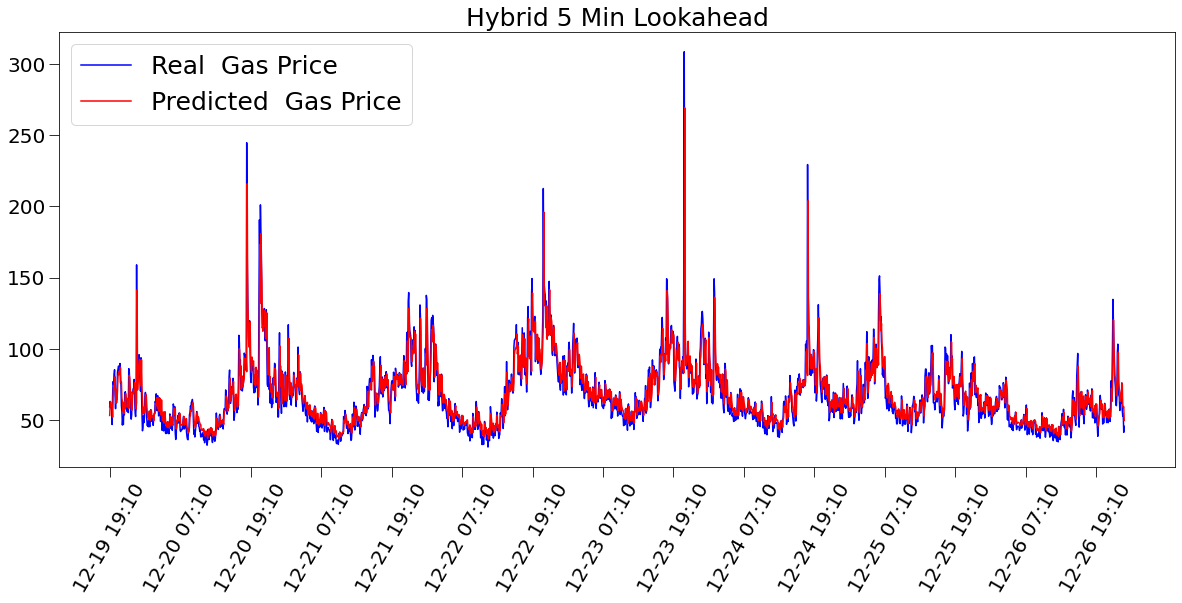

In [49]:
#Minmax scaler has been fit with nd data, add dummy columns so the scaler can be applied to min gas rpice
pred_descaled= (scaler.inverse_transform(array([yhat,]*(len(inputs))).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler.inverse_transform(array([y_val,]*(len(inputs))).transpose()[0][0]))[ :, :1]


f, (ax3) = plt.subplots(1, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(8)
ax3.set_title('Hybrid 5 Min Lookahead', size=25)
ax3.plot(groud_truth_descaled, color='blue',label='Real '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='Predicted '+' Gas Price')

ax3.legend(loc='upper left',prop={'size': 25})
plt.setp(ax3, xticks=ticks, xticklabels=labels)
ax3.tick_params(axis='x', labelrotation=60,size=10, labelsize=20)
ax3.tick_params(axis='y', labelsize=20,size=10)

print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

# Lets look at the 10 step lookahead

In [52]:
# Generate data for the 1 step model

#Create Training Examples for all lookaheads
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1
n_step_lookahead = 10

X_train, y_train, X_val, y_val, scaler = generate_training_val_examples_univariate_output(data)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [53]:
#Load 10 step model
model = keras.models.load_model('Hybrid Univarite3/month0_10_step_lookahead_Hybrid')

In [54]:
X_train.shape

(4832, 2016, 1)

In [55]:
yhat = model.predict(X_val, verbose=1)

65/65 [==============================] - 3s 23ms/step


In [56]:
ticks, labels = generate_ticks_lables(X_train, X_val, y_train, y_val, 144, 1)

RMSE 19.074829382722392
MAE 12.96347269571774
MAPE 0.18702844774734162
R^2 0.3644954669976387


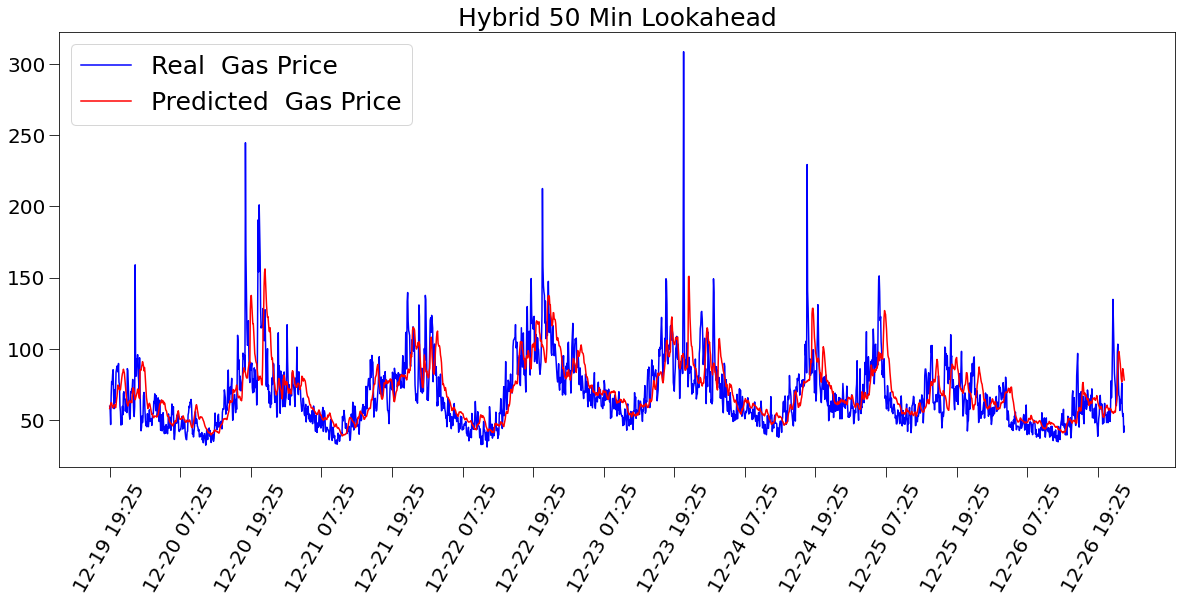

In [57]:
#Minmax scaler has been fit with nd data, add dummy columns so the scaler can be applied to min gas rpice
pred_descaled= (scaler.inverse_transform(array([yhat,]*(len(inputs))).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler.inverse_transform(array([y_val,]*(len(inputs))).transpose()[0][0]))[ :, :1]
#groud_truth_descaled= (scaler.inverse_transform(array([y_val,]*(len(inputs))).transpose()[0][0]))[ :, :1]

f, (ax3) = plt.subplots(1, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(8)
ax3.set_title('Hybrid 50 Min Lookahead', size=25)
ax3.plot(groud_truth_descaled, color='blue',label='Real '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='Predicted '+' Gas Price')

ax3.legend(loc='upper left',prop={'size': 25})
plt.setp(ax3, xticks=ticks, xticklabels=labels)
ax3.tick_params(axis='x', labelrotation=60,size=10, labelsize=20)
ax3.tick_params(axis='y', labelsize=20,size=10)

print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))